# Code quality of life changes to make:

- build fences between classes as best as possible.
- add relevant math to docstrings for easy reference.
- create/use data classes for:
    - flightpath
    - posterior
    - state

# From model to utility-function-gradient

In this notebook we follow the path from a user-provided test problem (steady state advection diffusion equation), over how measurements are taken along a path characterized by flight path parameters `alpha`, to the utility function and its gradient. The main purpose of this notebook is to check that
1. after changing the source class structure, everything still works
2. the gradient computation still works after its code is put from its model specific form into the general source code
3. show how to use the main source functions for use in the `Optimization` class

## Imports

In [33]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from FOM_stationary import FOM_stationary as FOM
from MyDrone import MyDrone as Drone
from OEDUtility import OEDUtility

from DetectorApprox import DetectorPointwise as Detector

from NavigationCircle import NavigationCircle as Navigation
# from NavigationFreePath import NavigationFreePath as Navigation

%load_ext autoreload
%autoreload 2

import time
tStart_notebook = time.time()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## User settings

In [2]:
n_para = 5
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_test = 100 # resolution for 1D plots
n_test_2d = 60 # resolution for 2D plots (50: ~1 min runtime for dt = 0.01)

## Full-order model setup

First we initialize the full-order model. The model is user-specific, but we have imported it here under the name `FOM` such that we can switch out models easily by changing the import statement only (as long as there are no model-specific settings we also need to make).

In [3]:
tStart = time.time()

fom = FOM(mesh_shape='houses')

print("Runtime of this block: {} s".format(time.time()-tStart))

Runtime of this block: 5.998983144760132 s


**Note:** I'm not sure why the initialization of the model is taking so long, it didn't used to. I have to double-check what's happening.

For a given parameter, we can solve the model with a call to `solve`. `solve` is a call any `FullOrderModel` subclass has to have.

In [4]:
para_true = np.ones((n_para,))
para_true = np.zeros((n_para,))
para_true[0] = 1
state = fom.solve(parameter=para_true)

In [5]:
para_true

array([1., 0., 0., 0., 0.])

In contrast, we don't require `FullOrderModel` to have a plot function. However, since it's useful to look at the state and we have a plot function for our example model, it doesn't hurt to take a look:

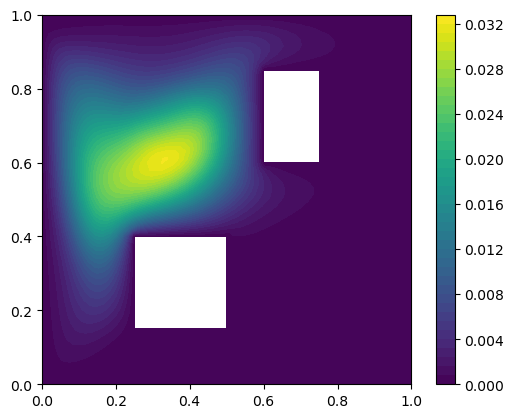

In [6]:
fom.plot(state)

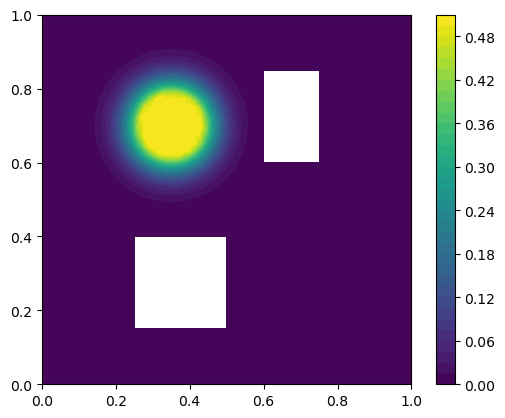

In [7]:
a = fom.assemble_forcing(para_true)
fom.plot(a)

By the way, the output of `fom.solve` is a `State`-object. Using a `State` object makes it easier for us to pass information around. Only the full-order model and the drone need to know how to interact with the state, and all of those are user-defined, so the `State` class makes it easier for the user to keep all the information related to a specific model solve.

**TODO:** One the same note, we should really introduce a `Flightpath` object too to keep track of how `alpha`, its positions, the chosen timediscretization, and the derivatives are connected. 

## Prior

In our discussion we said we wanted the prior to be a part of the `FullOrderModel` class. I'm not entirely sure I like that, I think one could make an argument for keeping it separate, in particular once we go into parameter space reduction. For now it's part of it though.

First, we need to specify the prior. It's assumed to be a Gaussian, which is uniquely specified by its mean and covariance matrix. For our example here we set the prior to be iid, centered around 0.

In [8]:
prior_mean = np.zeros((n_para,))
prior_mean[0] = 0.5
prior_covar = var_prior*np.eye(n_para)
print("prior_mean\n", prior_mean)
print("prior_covar\n", prior_covar)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

prior_mean
 [0.5 0.  0.  0.  0. ]
prior_covar
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


We can sample the prior by calling `fom.sample`, though for our OED problem we won't need this until we go into parameter space reduction:

In [9]:
fom.sample(n_samples = 2)

array([[ 1.06423843, -0.8113748 ],
       [ 1.60903934, -1.35682804],
       [ 0.185876  ,  0.40951265],
       [ 0.99623431,  0.4427034 ],
       [-0.14560587, -0.37407823]])

## Drone

The drone is also user-defined, for two main reasons:
- it needs to interact with the state, which depends on the full-order model, and hence on the FE solver (or whichever discretization is used). We can therefore not specifiy a uniform way to interact with the state
- the parameterization of the flight path is model dependent

Similar to `FOM` above, we have already imported the user-defined version of `Drone`.

> Note: removed fom reference from drone (unused)

> Possibly introduce flightpath class: similar to FOM -> states (solution with fixed params), we would have Drone -> flightpaths (path with fixed params)

In [34]:
drone = Drone(navigation = Navigation(), detector = Detector(fom = fom))

In [32]:
from MyCombinedDroneAngular import MyDrone as CombinedDrone
new_drone = CombinedDrone(eval_mode = "point-eval")

ModuleNotFoundError: No module named 'MyCombinedDroneAngular'

The argument `eval_mode` is specific to our model problem since we want to compare and test out different ways of measurements. It can be expected that the user only has a single one in mind. For us, the options we had implemented are: "point-eval", "uniform", "gaussian, truncated". However, since I want to get home at some point, I'm only copying over "point-eval" right now, I'll double-check the others another time.

**TODO:** other measurement modes (gaussian, etc.)

The flightpath is parameterized using the "control" `alpha`. For our example here, `alpha = [radius, speed]`. Any `Drone` object has to have the function `get_trajectory` which returns the flight path for a given flight path parameterization.

In [46]:
alpha = np.array([0.25, 0.2])
flight = drone.plan_flight(alpha = alpha)
flightpath, grid_t_drone = flight.flightpath, flight.grid_t

In [ ]:
new_alpha = np.array([np.pi/2, 0.3, 1, 1, 1, 1, 1])
# new_alpha = 0.3 * np.ones((21, ))
# new_alpha[0] = np.pi/2
flightpath, grid_t_drone = new_drone.get_trajectory(alpha=new_alpha)

For our case here we can easily plot the flight path:

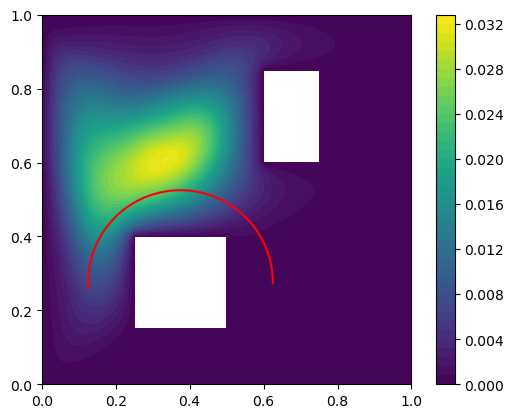

In [47]:
fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")

Another function every `Drone` subclass has to have implemented is `measure`:

In [ ]:
measurements = drone.measure(state=state, flightpath=flightpath, grid_t=grid_t_drone)

$\| d - d_{obs} \|_{\Sigma^{-1}_{noise}}$ (noise scales the uncertainty of this difference)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(grid_t_drone, measurements)
ax.set_xlabel("time (drone is flying)")
ax.set_ylabel("measurement")
ax.set_title("point-wise measurement along flightpath")

## Inverse Problem

We now come to the classes that are no longer user-dependent. The first one is `InverseProblem`. It should function regardless of what the forward model is.

`InverseProblem` needs to know the forward model, especially since it contains the prior currently, and the drone. `InverseProblem` is the class that generates the posterior distribution for a given flightpath as one of its outputs, therefore it doesn't get a fixed flight path in its initialization

In [ ]:
inversion = InverseProblem(fom, drone)

In [ ]:
new_inversion = InverseProblem(fom, new_drone)

We precompute the states for a linear combination of parameter basis vectors. For now we use the unit basis, we'll take a closer look at other bases later in the context of parameter space reduction:

In [ ]:
tStart = time.time()
inversion.compute_states(np.eye(n_para))
print("State solve time ({} parameters): {} s".format(n_para, time.time()-tStart))

In [ ]:
tStart = time.time()
new_inversion.compute_states(np.eye(n_para))
print("State solve time ({} parameters): {} s".format(n_para, time.time()-tStart))

For curiosity and mental health, let's take a look at the states we've gotten for this basis:

In [ ]:
for i in range(5):  # change i = 1, ..., n_para

    fom.plot(inversion.states[i])

In [ ]:
for i in range(5):  # change i = 1, ..., n_para

    fom.plot(new_inversion.states[i])

Beautiful.

**TODO:** For optimizing the inverse problem, we'll probably want to oursource some computations to, e.g., `hIppylib`. I have not done that yet. 

## Posterior distribution

For a given flight path and measurement data along this path, the `InverseProblem` can generate a posterior distribution for us. For each flightpath, we get a different posterior.

If no measurement data is provided, we can still create an object that handles the "posterior" covariance matrix for us. Note that under our linearity assuptions the posterior covariance matrix is data-independent.

**Note:** `InverseProblem` is potentially a misnomer.

In [ ]:
posterior = inversion.compute_posterior(alpha)

In [ ]:
new_posterior = new_inversion.compute_posterior(new_alpha)

If a flightpath was already computed, it should be provides to avoid duplicates and potential changes. The `flightpath` always needs its time discretization (`grid_t_drone` above) in order to be interpreted. So `grid_t` must be passed too in this case.

**Note:** This is an example for why it would make sense to introduce a `Flightpath` class that stores all variables together within one object.

In [ ]:
posterior = inversion.compute_posterior(alpha, flightpath=flightpath, grid_t=grid_t_drone)

In [ ]:
new_posterior = new_inversion.compute_posterior(new_alpha, flightpath=flightpath, grid_t=grid_t_drone)

Let's take a look at the posterior mean. Remember that our prior was centered around 0, and our "true" parameter (the one from which we got the data), has 1's everywhere.

In [ ]:
posterior.compute_mean(data=measurements)[0]

With more trust in the data (increase `c_scaling` in `InverseProblem`) or less trust in the prior (increase the scaling factor when defining the prior covariance matrix) we see that we indeed converge to the true solution (we didn't apply any noise and have lots of measurements, so that's expected).

We could plot the marginal distribution but for now I think it's ok.

## OED utility function
Time to judge how good our flight path really is. The utility function draws its main information from the inversion.

**TODO:** actually, I don't think `OEDUtility` interacts with anything but the posterior at which it is asked to compute something. I don't think it even needs to be a class but just a collection of functions. I'm keeping it anyway since it makes structural sense and might get more functions in the future.

In [ ]:
utility = OEDUtility(inversion)

In [ ]:
utility = OEDUtility(new_inversion)

For any flightpath characterization `alpha`, we can evaluate the utility of its associated flightpath by computing the utility function of the posterior covariance matrix.

**Note:** Again an example in favor of introducing a `Flightpath` class. For a given `alpha` we'd instantiate this class, and if needed it would then compute the posterior for us. The way it's implemented currently we pass the posterior around sepparately from `alpha`, which is just super prone to errors.

In [ ]:
alpha = np.array([0.25, 0.2])
posterior = inversion.compute_posterior(alpha)

print("A-OED:", utility.eval_utility(posterior, mode="A"))
print("D-OED:", utility.eval_utility(posterior, mode="D"))
print("E-OED:", utility.eval_utility(posterior, mode="E"))

In [ ]:
new_alpha = np.array([np.pi/2, 0.5, 0.2, 0.1, 0.1, 1, 2, 3, 0])
posterior = new_inversion.compute_posterior(new_alpha)

print("A-OED:", utility.eval_utility(posterior, mode="A"))
print("D-OED:", utility.eval_utility(posterior, mode="D"))
print("E-OED:", utility.eval_utility(posterior, mode="E"))

For comparison, for the prior we have:

In [ ]:
print("A-OED (prior):", np.trace(fom.prior_covar))
print("D-OED (prior):", la.det(fom.prior_covar))
print("E-OED (prior):", np.max(la.eigh(fom.prior_covar)[0]))

To get a feeling for the three functions, let's plot them over our control domain for alpha. First, we need to figure out the admissible domain. We don't want the drone to collide with the boundary of the domain (restriction on the radius). The speed is - theoretically - unrestricted. However, I'm not entirely sure if, when we repeat locations, this would change our noise covariance or if we can just treat them as if there was no overlap. This is only a question for the stationary problem of course.

Until I've figured this out I restrict the maximum speed such that, for minimial radius, the drone will fly at most one circle but not start on a second.

In [ ]:
# admissible domain
radius_min = la.norm(np.array([0.75, 0.55])/2 - np.array([0.5, 0.4])) # 0.1767
radius_min = 0.1
radius_max = la.norm(np.array([0, 0.55])/2) # 0.275
radius_max = 0.5
# drone may not collide with buildings or leave the domain

final_time = grid_t_drone[-1]
speed_min = 2 * np.pi * radius_min / final_time
speed_max = 2 * np.pi * radius_max / final_time
# maximum speed is chosen such that go for at most one circle

Theoretically we could re-visit measurement locations. I need to think about what that means for the noise model though.

Now we compute the OED-utility values for all combinations of radius and speed:

In [ ]:
tStart = time.time()

# grid over admissible domain
vec_speed_2d = np.linspace(0.05 * speed_max, speed_max, n_test_2d)
vec_radius_2d = np.linspace(radius_min, radius_max, n_test_2d+1)

vec_speed = np.linspace(0.05 * speed_max, speed_max, n_test)
vec_radius = np.linspace(radius_min, radius_max, n_test+1)
# note: I'm not making the vectors the same lengths so I don't accidentally confuse the directions

# initialize
util = np.zeros((3, n_test_2d+1, n_test_2d))

drone = Drone()
inversion = InverseProblem(fom, drone)
utility = OEDUtility(inversion)

for i in range(n_test_2d+1):
    for j in range(n_test_2d):
        
        alpha = np.array([vec_radius_2d[i], vec_speed_2d[j]])
        posterior = inversion.compute_posterior(alpha)
        
        util[0, i, j] = utility.eval_utility(posterior, mode="A")
        util[1, i, j] = utility.eval_utility(posterior, mode="D")
        util[2, i, j] = utility.eval_utility(posterior, mode="E")
        
print("Runtime of this block: ", (time.time()-tStart)/60, "min.")

Finally we can plot the OED-utility. A- and D-OED look fairly similar, E-OED has almost a shock-like behavior. This is because if the drone isn't fast enough for its radius, it will never reach the areas of the state that are influenced by the 5th forcing function. In this case, the uncertainty for the 5th parameter entry will not get reduced, i.e., at least one eigenvalue will remain unchanged when updating the prior. Since the prior was chosen iid., the maximum eigenvalue of the posterior is then the same as the prior. The E-OED utility function will remain constant until the combination of speed and radius is able to detect all forcing functions. At this point the uncertainty in all directions improves and the E-OED utility begins to improve.

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i in range(3):
    axs[i].pcolormesh(vec_speed_2d, vec_radius_2d, util[i, :, :])
    axs[i].set_xlabel("Speed")
    axs[i].set_ylabel("Radius")
    
axs[0].set_title("A-OED")
axs[1].set_title("D-OED")
axs[2].set_title("E-OED")

In [ ]:
x_max, x_min = np.max(vec_speed_2d), np.min(vec_speed_2d)
y_max, y_min = np.max(vec_radius_2d), np.min(vec_radius_2d)
data_aspect_ratio = (x_max - x_min) / (y_max - y_min)

# Set figure size based on data aspect ratio
desired_width = 5  # Adjust width as desired
figure_height = desired_width / data_aspect_ratio

# fig, ax = plt.subplots(figsize=(desired_width, figure_height))
fig, ax = plt.subplots()

# Use imshow with extent
im = ax.imshow(np.flipud(util[0, :, :]), extent=(x_min, x_max, y_min, y_max), aspect=data_aspect_ratio)

# Set labels and title
ax.set_xlabel("Speed")
ax.set_ylabel("Radius")
# ax.set_title("A-OED")

# Create and position the colorbar
fig.colorbar(im, label="A-OED")

plt.tight_layout()

plt.show()


## Derivative of the utility function

### derivative of the position
We take a quick look at the derivatives of the position, because there's an interesting observation to be made (spoiler!). It's also good for double-checking and getting an idea for how the derivatives behave in time.

In [ ]:
der_all = drone.d_position_d_control(alpha, grid_t_drone)
der_all.shape # parameters, (x,y), grid_t

In [ ]:
# der_all = new_drone.d_position_d_control(new_alpha, grid_t_drone)
new_alpha = np.array([np.pi/2, 0.5, 0.2, 0.1, 0.1, 1, 2, 3, 0])
new_der_all = new_drone.d_position_d_control(new_alpha, np.array([0,1,4]))
print(new_der_all.shape)
new_der_all

In [ ]:
t = 0.2
k = np.argmin(np.abs(grid_t_drone - t))
der = der_all[:, :, k]
pos = flightpath

der_radius = der[0, :]
der_speed = der[1, :]

fom.plot(state)
plt.plot(pos[:, 0], pos[:, 1], color="r")
plt.plot([pos[k, 0]], [pos[k, 1]], marker = "o", color = "r")

plt.plot([pos[k, 0], pos[k, 0] + 1 * der_speed[0]], [pos[k, 1], pos[k, 1] +1 * der_speed[1]])  # speed
plt.plot([pos[k, 0], pos[k, 0] + 0.1 * der_radius[0]], [pos[k, 1], pos[k, 1] + 0.1 * der_radius[1]])  # radius

Both derivatives are nice and interpretable close to `t=0`. The more time passes, the weirder the derivatives look. That's because the more time passes the more influence do the radius and the speed have on the position, and the derivatives can consequently be expected to become larger and larger (If this is not clear, think about the difference quotient). 

This observation might be important for us because since we are planning to puzzle the flightpath together from various curves. It might pose a limit on how long we can make each segment of the control in comparison to the time discretization of the drone. I need to think about this some more.

### Derivatives of the OED-utility function
We've arrived at the final stage - the derivatives of the OED-utility function! We get the derivatives from the `OEDUtility` class with the function `eval_utility`. To specify the position `alpha` at which we want to compute the derivative we pass the associated `Posterior` object. This is not quite intuitive. I think it makes more sense - also for avoiding unnecessary re-computations - to have a `Flightpath` object for each control parameter vector `alpha` that contains the flight path positions, time grid, and any attributes computed along the way like the derivatives. 

Note below that so far we only have the derivatives for A- and D-OED, as well as for "D-inverse" which is the determinant of the inverse posterior covariance matrix (instead of "D", the determinant of the posterior covariance matrix).

Feel free to change the values of `speed_test` and `radius_test` below. They specify where we evaluate the derivative. In addition, we compute the OED-utility function values along `vec_radius x {speed_test}` and `{radius_test} x vec_speed` to visualize whether the derivative is indeed correct.

**Note:**
For the optimization routine, the first part of this block (between `##`) is the most important, since it shows the calls the optimization routine will need to make.

In [ ]:
# user input: Where to evaluate the derivative:
speed_test = 0.08 # choose value between 0 and max(vec_speed) \approx 0.27768018
radius_test = 0.22 # choose value between radius_min \approx 0.1767766952966369 and radius_max \approx 0.275

tStart = time.time()

## IMPORTANT FOR THE OPTIMIZATION !!
alpha_test = np.array([radius_test, speed_test])
posterior_ref = inversion.compute_posterior(alpha_test)

util_ref = np.zeros(4)
util_ref[0] = utility.eval_utility(posterior_ref, mode="A")
util_ref[1] = utility.eval_utility(posterior_ref, mode="D")
util_ref[2] = utility.eval_utility(posterior_ref, mode="D-inverse")
util_ref[3] = utility.eval_utility(posterior_ref, mode="E")

der_ref_A = utility.d_utility_d_control(posterior_ref, mode="A")
der_ref_D = utility.d_utility_d_control(posterior_ref, mode="D")
der_ref_Dinv = utility.d_utility_d_control(posterior_ref, mode="D-inverse")
## done with the important part

util_test = np.zeros((4, 2, n_test+1))
for i in range(n_test+1):
    
    if i < n_test:
        # vec_speed has one entry less (to avoid accidentally transposing the results)
        
        alpha = np.array([radius_test, vec_speed[i]])
        posterior = inversion.compute_posterior(alpha)

        util_test[0, 0, i] = utility.eval_utility(posterior, mode="A")
        util_test[1, 0, i] = utility.eval_utility(posterior, mode="D")
        util_test[2, 0, i] = utility.eval_utility(posterior, mode="D-inverse")
        util_test[3, 0, i] = utility.eval_utility(posterior, mode="E")
        
    alpha = np.array([vec_radius[i], speed_test])
    posterior = inversion.compute_posterior(alpha)

    util_test[0, 1, i] = utility.eval_utility(posterior, mode="A")
    util_test[1, 1, i] = utility.eval_utility(posterior, mode="D")
    util_test[2, 1, i] = utility.eval_utility(posterior, mode="D-inverse")
    util_test[3, 0, i] = utility.eval_utility(posterior, mode="E")
    
print("Runtime of this block: ", (time.time()-tStart)/60, "min.")

First the plot for A-OED:

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
scale = 0.01
norm = la.norm(der_ref_A)

axs[0].pcolormesh(vec_speed_2d, vec_radius_2d, util[0, :, :])
axs[0].plot([vec_speed_2d[0], vec_speed_2d[-1]], [radius_test, radius_test], color="r", marker=None)
axs[0].plot([speed_test, speed_test], [vec_radius_2d[0], vec_radius_2d[-1]], color="r", marker=None)
axs[0].plot([speed_test, speed_test - 0.5 * scale * der_ref_A[1]], 
            [radius_test, radius_test - 0.5 * scale * der_ref_A[0]], 
            color = "w", marker = None)
axs[0].set_xlabel("speed")
axs[0].set_ylabel("radius")
axs[0].set_title("A-OED")

axs[1].plot(vec_radius, util_test[0, 1, :])
axs[1].plot([radius_test], util_ref[0], marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + scale], 
            [util_ref[0], util_ref[0]+scale*der_ref_A[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed, util_test[0, 0, :-1])
axs[2].plot([speed_test], util_ref[0], marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + scale], 
            [util_ref[0], util_ref[0]+scale*der_ref_A[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")

In the plot on the left, the sign for the gradient is chosen such that it points into the steepest decent direction.

Here's the plot for D-OED:

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
scale = 0.01
norm = la.norm(der_ref_D)

axs[0].pcolormesh(vec_speed_2d, vec_radius_2d, util[1, :, :])
axs[0].plot([vec_speed_2d[0], vec_speed_2d[-1]], [radius_test, radius_test], color="r", marker=None)
axs[0].plot([speed_test, speed_test], [vec_radius_2d[0], vec_radius_2d[-1]], color="r", marker=None)
axs[0].plot([speed_test, speed_test - 0.5 * scale * der_ref_D[1]], 
            [radius_test, radius_test - 0.5 * scale * der_ref_D[0]], 
            color = "w", marker = None)
axs[0].set_xlabel("speed")
axs[0].set_ylabel("radius")
axs[0].set_title("D-OED")

axs[1].plot(vec_radius, util_test[1, 1, :])
axs[1].plot([radius_test], util_ref[1], marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + scale], 
            [util_ref[1], util_ref[1]+scale*der_ref_D[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed, util_test[1, 0, :-1])
axs[2].plot([speed_test], util_ref[1], marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + scale], 
            [util_ref[1], util_ref[1]+scale*der_ref_D[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")

Instead of minimizing the D-OED criterion, we've also talked about maximizing its inverse, which can be computed more efficiently. In this case the sign for the derivative in the 2D plot was chosen to point into the steepest ascend direction.

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
scale = 0.01
norm = la.norm(der_ref_D)

axs[0].pcolormesh(vec_speed_2d, vec_radius_2d, 1/util[1, :, :])
axs[0].plot([vec_speed_2d[0], vec_speed_2d[-1]], [radius_test, radius_test], color="r", marker=None)
axs[0].plot([speed_test, speed_test], [vec_radius_2d[0], vec_radius_2d[-1]], color="r", marker=None)
axs[0].plot([speed_test, speed_test + 0.2 * scale * der_ref_Dinv[1]], 
            [radius_test, radius_test + 0.2 * scale * der_ref_Dinv[0]], 
            color = "w", marker = None)
# positive gradient direction because we want to maximize

axs[0].set_xlabel("speed")
axs[0].set_ylabel("radius")
axs[0].set_title("D-OED, inverse")

axs[1].plot(vec_radius, util_test[2, 1, :])
axs[1].plot([radius_test], util_ref[2], marker="x", markersize=8, color="r")
axs[1].plot([radius_test, radius_test + scale], 
            [util_ref[2], util_ref[2]+scale*der_ref_Dinv[0]], 
            marker="", markersize=8, color="r")
axs[1].set_xlabel("radius")

axs[2].plot(vec_speed, util_test[2, 0, :-1])
axs[2].plot([speed_test], util_ref[2], marker="x", markersize=8, color="r")
axs[2].plot([speed_test, speed_test + scale], 
            [util_ref[2], util_ref[2]+scale*der_ref_Dinv[1]], 
            marker="", markersize=8, color="r")
axs[2].set_xlabel("speed")

## What's there:
- setup of the posterior
- utility function evaluation
- utility function derivatives for point-wise measurements (A, D, D-inverse OED)

I think this should be enough to get started on the optimization routine.

## What's missing?

- class `Flightpath` to keep all computed values for a given `alpha` together and avoid mix-ups
- E-OED derivative
- still need to copy definition of non-pointwise measurement functions over
- derivatives of convolution type measurements and Weierstrass trick
- parameter space reduction
- optimization of the code (don't use `la.inv`, make sure not to re-compute different values, get rid of some `for`-loops)

## The End.

In [ ]:
runtime_notebook = time.time()-tStart_notebook
print("Runtime of this notebook: {} min".format(runtime_notebook / 60))

# Drone flightpath

The drone flightpath requires a position at time `t` derived from parameters `alpha`. We also need the derivative of position at time `t` as a function of the parameters.

We may wish to have a path that does not have any velocity that we then add velocity to, i.e., an arc length paramaterization that we add a velocity to (some velocities may be not allowable as they may induce other parameters such as angular velocity that may not be allowable).

The way these paths are currently handled, it may be optimal to simply increase the velocity as much as possible. I don't think we have an control on the precision of the measurments we are taking as a function fo the velocity.

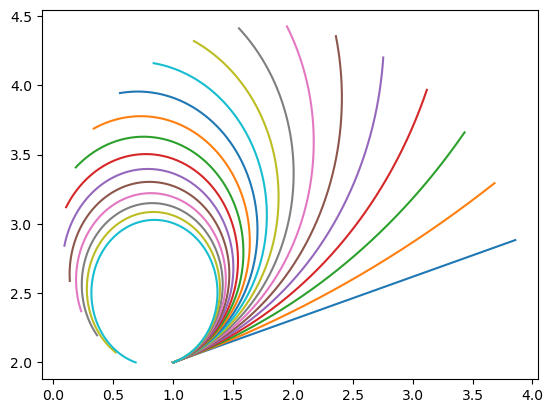

In [12]:
from CircularPath import CircularPath

alpha = {
    "initial x" : 1.,  # initial position vector
    "initial y" : 2.,  # initial position vector
    "initial heading" : 2.,  # initial heading (radians)
    "velocity" : 1,  # velocity
    "angular velocity" : 2,  # angular velocity
}

plt.figure()
t = np.arange(0, 3, 0.01)
# for av in np.arange(-2, 2, 0.1):
for av in np.arange(0, 2, 0.1):
    alpha = np.array([1., 2., 0.3, 1, av])
    path = CircularPath(alpha)    
    pos = path.position(t)
    plt.plot(pos[:,0], pos[:,1])


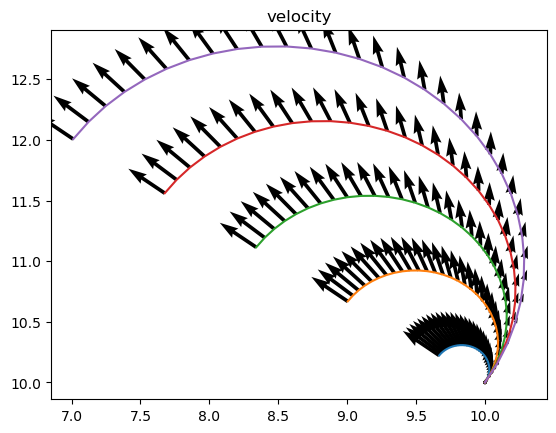

In [13]:
plt.figure()
for v in np.arange(0.1, 1, 0.2):
    t = np.arange(0, 2*np.pi, 0.2)
    
    alpha = np.array([10., 10., 1, v, 0.5])
    path = CircularPath(alpha, initial_time=0)    
    pos = path.position(t)

    derivs = path.d_position_d_alpha(t)
    # keys = ["initial x", "initial y", "initial heading", "velocity", "angular velocity"]
    
    key = "velocity"
    dx = derivs[key][:,0]
    dy = derivs[key][:,1]
    
    plt.plot(pos[:,0], pos[:,1])
    plt.quiver(pos[:,0], pos[:,1], dx, dy)
    plt.title(key)

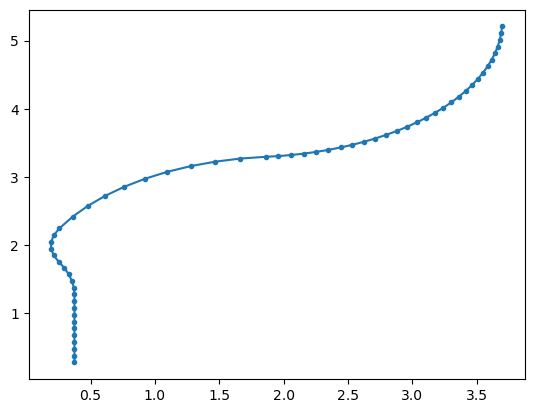

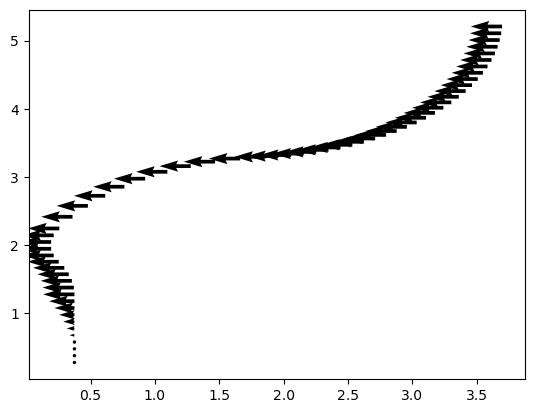

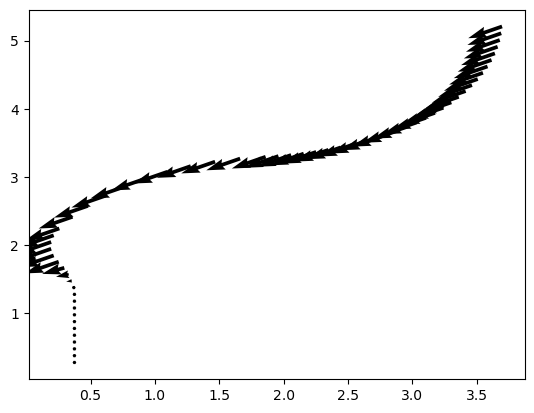

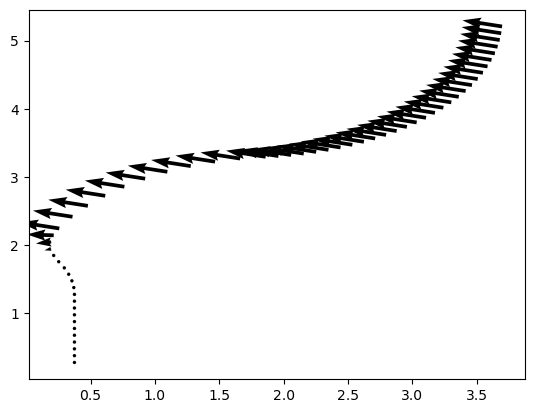

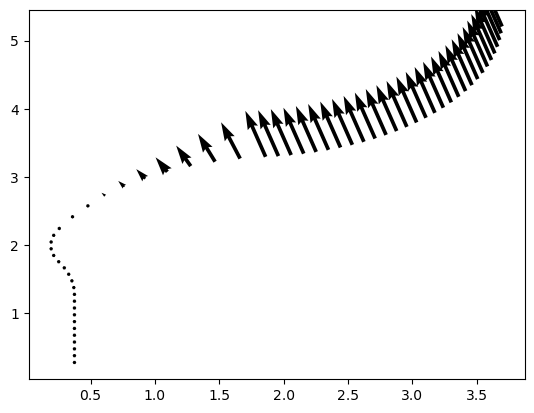

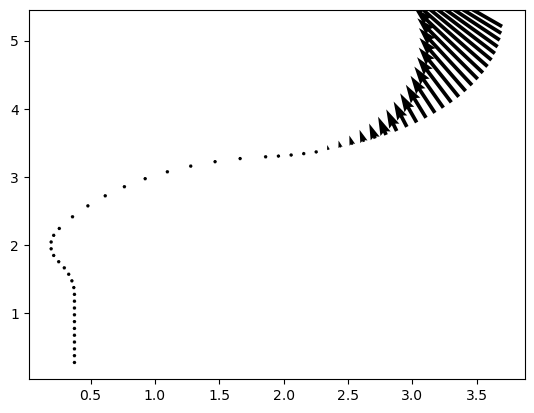

In [19]:
from CombinedCircularPath import CombinedCircularPath

center = np.array([0.75 / 2, 0.55 / 2])

path = CombinedCircularPath( center[0], center[1], np.pi/2, np.array([[1, 0], [1, 1], [1, -2], [2, -1], [1, 0.5]]), np.array([0, 1, 1.5, 1.99, 3]))
plt.figure()
t = np.arange(0, 6, 0.1)
pos = path.position(t)
plt.plot(pos[:,0], pos[:,1], '.-')
deriv = path.d_position_d_parameters(t)["angular velocity"]

# plot the boundaries between the segments

deriv.shape
for i in range(deriv.shape[1]):
    plt.figure()
    plt.quiver(pos[:,0], pos[:,1], deriv[:,i, 0], deriv[:,i, 1])


In [23]:
from CirclePath import CirclePath

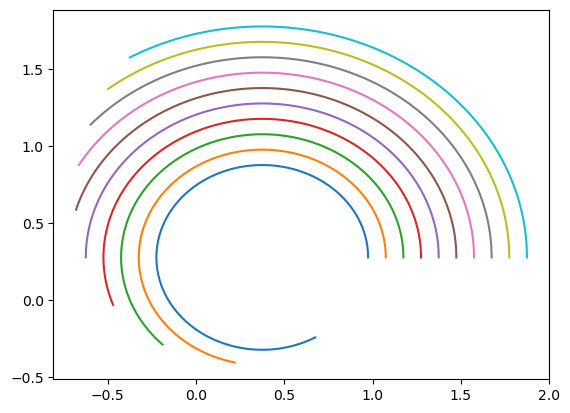

In [24]:
for radius in np.arange(0.6, 1.6, 0.1):
    # radius = 1
    velocity = 1
    path = CirclePath([radius,velocity])
    t = np.linspace(0, np.pi, 100)
    pos = path.position(t)
    plt.plot(pos[:,0], pos[:,1])

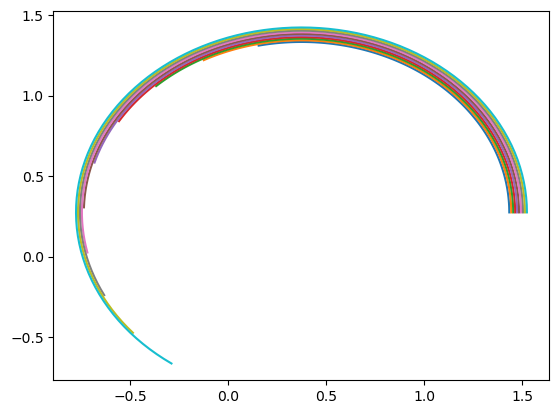

In [25]:
for velocity in np.arange(0.6, 1.6, 0.1):
    radius = 1 + velocity/10
    # velocity = 1
    path = CirclePath([radius,velocity])
    t = np.linspace(0, np.pi, 100)
    pos = path.position(t)
    plt.plot(pos[:,0], pos[:,1])

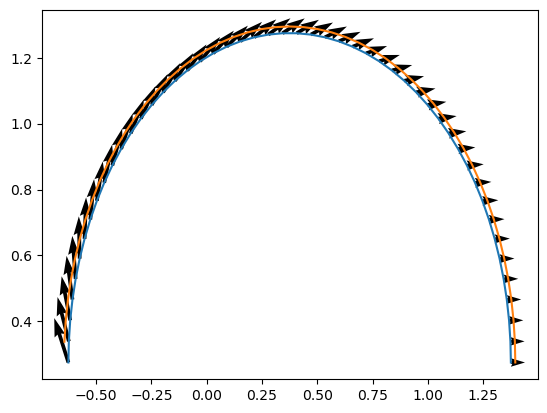

In [26]:
radius = 1
velocity = 1
path = CirclePath([radius,velocity])
t = np.linspace(0, np.pi, 50)
pos = path.position(t)
deriv = path.d_position_d_radius(t)

plt.figure()
plt.quiver(pos[:,0], pos[:,1], deriv[:, 0], deriv[:, 1])
plt.plot(pos[:,0], pos[:,1])

radius = 1.02
velocity = 1
path = CirclePath([radius,velocity])
t = np.linspace(0, np.pi, 50)
pos = path.position(t)
plt.plot(pos[:,0], pos[:,1])

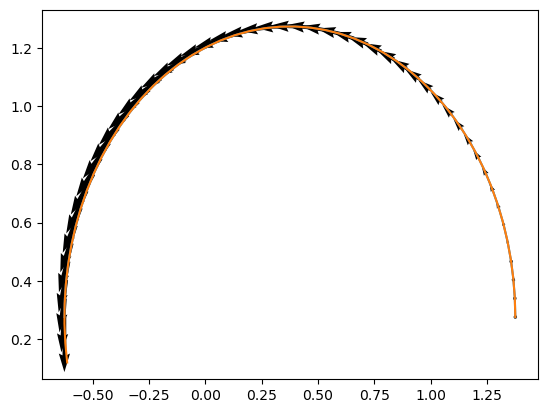

In [27]:
radius = 1
velocity = 1
path = CirclePath([radius,velocity])
t = np.linspace(0, np.pi, 50)
pos = path.position(t)
deriv = path.d_position_d_velocity(t)

plt.figure()
plt.quiver(pos[:,0], pos[:,1], deriv[:, 0], deriv[:, 1])
plt.plot(pos[:,0], pos[:,1])

radius = 1
velocity = 1.05
path = CirclePath([radius,velocity])
t = np.linspace(0, np.pi, 50)
pos = path.position(t)
plt.plot(pos[:,0], pos[:,1])

# Derivatives that we need

We need:
- the derivatives of the position as a function of the parameters (see previous)
- the derivatives of the measurement as a function of position (if pointwise, this is simple; if we can transform states such that we can do pointwise measurements, then this is simple; this is simple because this is just the gradient of the state for a pointwise measurement, but we may be able to get away without doing the transform?)
- the derivatives of the optimal experimental design objective

These are all done already (thanks, Nicole!) for a circular path where the parameters are radius and speed.

$$\frac{\partial \Psi(\Sigma_\mathrm{post}(\mathbf{p}(\alpha)))}{\partial \alpha} = \frac{\partial \Psi}{\partial \Sigma_\mathrm{post}} \frac{\partial \Sigma_\mathrm{post}}{\partial \mathbf{u}} \frac{\partial \mathbf{u}}{\partial \mathbf{p}} \frac{\partial \mathbf{p}}{\partial \alpha}$$

$$\frac{\partial \Psi(\Sigma^{-1}_\mathrm{post}(\mathbf{p}(\alpha)))}{\partial \alpha} = \frac{\partial \Psi}{\partial \Sigma^{-1}_\mathrm{post}} \frac{\partial \Sigma^{-1}_\mathrm{post}}{\partial \mathbf{p}} \frac{\partial \mathbf{p}}{\partial \alpha}$$

# Basic gradient descent

The level of abstraction here is too much. I don't know where the drone/flightpath is stored in these objects. I don't know where the states are stored in these objects.

In [28]:
from Optimization import Optimization

# user input: Where to evaluate the derivative:
speed_test = 0.08 # choose value between 0 and max(vec_speed) \approx 0.27768018
radius_test = 0.22 # choose value between radius_min \approx 0.1767766952966369 and radius_max \approx 0.275

# speed_test = 0.27 # choose value between 0 and max(vec_speed) \approx 0.27768018
# radius_test = 0.3 # choose value between radius_min \approx 0.1767766952966369 and radius_max \approx 0.275
mode = 'A'

alpha = np.array([radius_test, speed_test])

drone = Drone()
inversion = InverseProblem(fom, drone)
utility = OEDUtility(inversion)

opt = Optimization(utility, inversion, mode = "A")
# a = opt.minimize(alpha, options={"disp" : True}, method='Nelder-Mead')
a = opt.minimize(alpha, options={"disp" : False}, method='L-BFGS-B')
# a = opt.minimize(a.x, options={"disp" : True}, method='Nelder-Mead')
# a = opt.minimize(alpha_new, options={"disp" : True}, method = 'BFGS')
print(a)

TypeError: MyDrone.__init__() missing 2 required positional arguments: 'navigation' and 'detector'

In [ ]:
flightpath, grid_t_drone = drone.get_trajectory(alpha=alpha)
fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.scatter(flightpath[0, 0], flightpath[0, 1], color='r')

In [ ]:
flightpath, grid_t_drone = drone.get_trajectory(alpha=a.x)
fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.scatter(flightpath[0, 0], flightpath[0, 1], color='r')

In [ ]:
x_max, x_min = np.max(vec_speed_2d), np.min(vec_speed_2d)
y_max, y_min = np.max(vec_radius_2d), np.min(vec_radius_2d)
data_aspect_ratio = (x_max - x_min) / (y_max - y_min)

# Set figure size based on data aspect ratio
desired_width = 5  # Adjust width as desired
figure_height = desired_width / data_aspect_ratio

# fig, ax = plt.subplots(figsize=(desired_width, figure_height))
fig, ax = plt.subplots()

# Use imshow with extent
im = ax.imshow(np.flipud(util[0, :, :]), extent=(x_min, x_max, y_min, y_max), aspect=data_aspect_ratio)

# Set labels and title
ax.set_xlabel("Speed")
ax.set_ylabel("Radius")
# ax.set_title("A-OED")

# Create and position the colorbar
fig.colorbar(im, label="A-OED")

plt.tight_layout()

plt.scatter(speed_test, radius_test, color='r')
plt.scatter(a.x[1], a.x[0], color='r', marker='*')

plt.show()


In [ ]:
# user input: Where to evaluate the derivative:
speed_test = 0.08 # choose value between 0 and max(vec_speed) \approx 0.27768018
radius_test = 0.22 # choose value between radius_min \approx 0.1767766952966369 and radius_max \approx 0.275
mode = 'A'

# alpha_old = np.array([radius_test, speed_test])
new_alpha = np.array([np.pi/2, .3, 1, 1, 1, 1, 1, 1, 1, 1, 1])
# new_alpha = np.array([3*np.pi/4, .2, 0, 0, 0, 0, 0, 0, 0, 0, 0])
# new_alpha = np.ones((10,))
# new_alpha[0] = np.pi/2
# new_alpha[1] = 0.3
alpha_old = new_alpha
alpha_new = alpha_old

new_drone = CombinedDrone(start = np.array([0.7, 0.3]))
new_inversion = InverseProblem(fom, new_drone)
utility = OEDUtility(new_inversion)

posterior_ref = new_inversion.compute_posterior(alpha_new)
dOEDdcontrol = utility.d_utility_d_control(posterior_ref, mode=mode)
print(utility.eval_utility(posterior_ref, mode=mode))

In [ ]:
flightpath, grid_t_drone = new_drone.get_trajectory(alpha=new_alpha)
fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.scatter(flightpath[0, 0], flightpath[0, 1], color='r')

In [ ]:
from Optimization import Optimization

mode = 'A'

# new_alpha = np.array([np.pi/2, .3, 1, 1, 1, 1, 1, 1, 1, 1, 1])

new_drone = CombinedDrone(start = np.array([0.7, 0.3]))
new_inversion = InverseProblem(fom, new_drone)
new_utility = OEDUtility(new_inversion)

opt = Optimization(new_utility, new_inversion, mode = "A")
a = opt.minimize(new_alpha, options={"disp" : True}, method='Nelder-Mead')
# a = opt.minimize(new_alpha, options={"disp" : True}, method='L-BFGS-B')
# a = opt.minimize(a.x, options={"disp" : True}, method='Nelder-Mead')
# a = opt.minimize(alpha_new, options={"disp" : True}, method = 'BFGS')
print(a)

In [ ]:
opt = Optimization(new_utility, new_inversion, mode = "A")
a = opt.minimize(a.x, options={"disp" : True}, method='Nelder-Mead')
# a = opt.minimize(a.x, options={"disp" : True}, method='L-BFGS-B')
# a = opt.minimize(a.x, options={"disp" : True}, method='Nelder-Mead')
# a = opt.minimize(alpha_new, options={"disp" : True}, method = 'BFGS')
print(a)

In [ ]:
# posterior_ref = new_inversion.compute_posterior(a.x)
# fom.prior_covar = posterior_ref.compute_covariance()

In [ ]:
flightpath, grid_t_drone = new_drone.get_trajectory(alpha=new_alpha)
fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.scatter(flightpath[0, 0], flightpath[0, 1], color='r')

In [ ]:
flightpath, grid_t_drone = new_drone.get_trajectory(alpha=a.x)
fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.scatter(flightpath[0, 0], flightpath[0, 1], color='r')

In [ ]:
lr = 1e-2

for i in range(200):
    posterior_ref = new_inversion.compute_posterior(alpha_new)
    dOEDdcontrol = utility.d_utility_d_control(posterior_ref, mode=mode)
    # print(dAdcontrol)
    alpha_old = alpha_new
    print(f"radius: {alpha_old[0]:7.4f}  speed: {alpha_old[1]:7.4f}   OED-{mode}: {utility.eval_utility(posterior_ref, mode=mode):7.4f}")
    alpha_new = alpha_old - lr * dOEDdcontrol

In [ ]:
alpha_new

In [ ]:
flightpath, grid_t_drone = new_drone.get_trajectory(alpha=alpha_new)
fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")

In [ ]:
from Optimization import Optimization
opt = Optimization(utility, new_inversion, mode = "A")
a = opt.minimize(alpha_new, options={"disp" : True}, method='Nelder-Mead')
# a = opt.minimize(alpha_new, options={"disp" : True}, method='L-BFGS-B')
# a = opt.minimize(alpha_new, options={"disp" : True}, method = 'BFGS')

In [ ]:
alpha_new = a.x
print(a.x)
print(a)

In [ ]:
flightpath, grid_t_drone = new_drone.get_trajectory(alpha=a.x)
fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.scatter(flightpath[0,0], flightpath[0,1], c='r')

In [ ]:
new_alpha = np.array([np.pi/2, .3, 1, 1, 1, 1, 1, 1, 1, 1, 1])

new_drone = CombinedDrone(start = np.array([0.7, 0.3]))
new_inversion = InverseProblem(fom, new_drone)
utility = OEDUtility(new_inversion)

posterior_ref = new_inversion.compute_posterior(alpha_new)
dOEDdcontrol = utility.d_utility_d_control(posterior_ref, mode=mode)
print(utility.eval_utility(posterior_ref, mode=mode))

flightpath, grid_t_drone = new_drone.get_trajectory(alpha=new_alpha)
fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.scatter(flightpath[0, 0], flightpath[0, 1], color='r')

In [ ]:
opt = Optimization(new_utility, new_inversion, mode = "A")
# a = opt.minimize(a.x, options={"disp" : True}, method='Nelder-Mead')
a = opt.minimize(a.x, options={"disp" : True}, method='L-BFGS-B')
# a = opt.minimize(a.x, options={"disp" : True}, method='Nelder-Mead')
# a = opt.minimize(alpha_new, options={"disp" : True}, method = 'BFGS')
print(a)

In [ ]:
flightpath, grid_t_drone = new_drone.get_trajectory(alpha=a.x)
transition_points = new_drone.path(alpha=a.x).transition_positions
fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.scatter(flightpath[0, 0], flightpath[0, 1], color='r')
plt.scatter(transition_points[:,0], transition_points[:,1], color='b')

In [ ]:
alpha_opt = a.x
alpha_new
alpha_opt

In [ ]:
alpha_opt

In [ ]:
mask = np.ones(alpha_new.shape, dtype=bool)
mask[:5] = 0

alpha_new_masked = alpha_new
alpha_new_masked[mask] = 0

alpha_new_masked[~mask] = alpha_opt[~mask]

opt = Optimization(new_utility, new_inversion, mode = "A")
a = opt.minimize(alpha_new_masked, options={"disp" : True}, method='Nelder-Mead', mask=mask)
# a = opt.minimize(alpha_new_masked, options={"disp" : True}, method='L-BFGS-B', mask=mask)
# a = opt.minimize(alpha_new_masked, options={"disp" : True}, method='Nelder-Mead', mask=mask)
# a = opt.minimize(alpha_new_masked, options={"disp" : True}, method = 'BFGS', mask=mask)
print(a)

In [ ]:
a.x

In [ ]:
flightpath, grid_t_drone = new_drone.get_trajectory(alpha=alpha_opt)
transition_points = new_drone.path(alpha=alpha_opt).transition_positions
fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
# plt.scatter(flightpath[0, 0], flightpath[0, 1], color='r')
plt.scatter(transition_points[:3,0], transition_points[:3,1], color='b')
plt.scatter(transition_points[3,0], transition_points[3,1], color='r')

In [ ]:
flightpath, grid_t_drone = new_drone.get_trajectory(alpha=a.x)
transition_points = new_drone.path(alpha=a.x).transition_positions
fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.scatter(flightpath[0, 0], flightpath[0, 1], color='r')
plt.scatter(transition_points[:,0], transition_points[:,1], color='b')

In [ ]:
flightpath, grid_t_drone = new_drone.get_trajectory(alpha=alpha_new_masked)
transition_points = new_drone.path(alpha=alpha_new_masked).transition_positions
fom.plot(state)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.scatter(flightpath[0, 0], flightpath[0, 1], color='r')
plt.scatter(transition_points[:3,0], transition_points[:3,1], color='b')
plt.scatter(transition_points[3,0], transition_points[3,1], color='r')

# Graph optimization

Since the drone object is so deeply integrated in the code base right now (I think probably unecessarily), we need to rebuild quite a bit of code.

Where are the states stored?

Where is the prior?!

In [ ]:
import networkx as nx
# Define the graph
num_nodes = 7

adjacency = {
    0 : (1, 2),
    1 : (0, 2, 4, 5),
    2 : (0, 1, 3, 4),
    3 : (2, 4, 6),
    4 : (1, 2, 3, 5, 6),
    5 : (1, 4, 6),
    6 : (3, 4, 5)
}

G = nx.Graph(adjacency)

node_positions = {
    0 : (.1, .3),
    1 : (.4, .5),
    2 : (.2, .8),
    3 : (.4, .5),
    4 : (.5, .6),
    5 : (.7, .5),
    6 : (.8, .2)
}

nx.set_node_attributes(G, node_positions, name="position")

In [ ]:
for edge in G.edges:
    print(edge)

In [ ]:
def kirchhoff_matrix(graph):
    """Matrix for balanced flow"""
    out = np.zeros((len(graph.nodes), len(graph.edges)), dtype=int)
    for j, edge in enumerate(graph.edges):
        out[edge[0], j] = 1
        out[edge[1], j] = -1
    return out
kirchhoff_matrix(G)

In [ ]:
for node in G.nodes:
    print(G.nodes[node]["position"])

In [ ]:
# inversion.drone.measure()
import dolfin as dl
inversion.fom.m_parameterized[4]

In [ ]:
# simplify call? seems silly to grab the drone from the inverse problem and somehow find the basis in the fom in the inverse problem
drone = Drone()
inversion = InverseProblem(fom, drone)
utility = OEDUtility(inversion)
inversion.get_states()

flightpath = np.array([[0.1, 0.1],[0.2, 0.2]])
grid_t = np.array([0])
basis_id = 4
inversion.drone.measure(flightpath, grid_t, inversion.fom.m_parameterized[basis_id])
inversion.drone.measure(flightpath, grid_t, inversion.states[basis_id])

In [ ]:
%%time
num_edge_samples = 100
num_edges = len(G.edges)
num_bases = len(inversion.fom.m_parameterized)
num_bases = len(inversion.states)
plt.figure()
fom.plot(state)
d_i_k = np.zeros((num_bases, num_edges, num_edge_samples))
for k, edge in enumerate(G.edges):  # for each edge k
    # define the path between the edges
    edge_path = np.linspace(
        G.nodes[edge[0]]["position"],
        G.nodes[edge[1]]["position"],
        num_edge_samples + 1  # add one since we reduce the number of samples by averaging
    )
    # get the gap between subsequent points along the edge path
    d_edge = np.linalg.norm(np.diff(edge_path, axis = 0), axis = -1)
    # get a centered edge path (not evaluated at the end nodes)
    edge_path = edge_path[:-1]*0.5 + edge_path[1:]*0.5
    plt.plot(edge_path[:,0], edge_path[:,1], color='r')
    plt.scatter(edge_path[0,0], edge_path[0,1], color='r')
    plt.scatter(edge_path[-1,0], edge_path[-1,1], color='r')
    for i in range(num_bases):  # and each basis i
        d_i_k[i, k, :] = inversion.drone.measure(  # ultimately, we want d*d dx so we compute (d dx^0.5) * (d dx^0.5)
            edge_path,
            np.array([0]), # grid_t
            # inversion.fom.m_parameterized[i]
            inversion.states[i]
        ) * np.sqrt(d_edge)

In [ ]:
for k in range(12):
    plt.figure()
    plt.plot(d_i_k[:,k,:].transpose());
    plt.title(f"{k}")

In [ ]:
%%time
M_k = np.zeros((num_bases, num_bases, num_edges))
for k, edge in enumerate(G.edges):
    # for each edge, get d_i_k and d_j_k for all bases
    M_k[:, :, k] = np.matmul(d_i_k[:, k, :], np.transpose(d_i_k[:, k, :])) # computing the integral

In [ ]:
i, j, k = 0, 1, 8
print(np.sum(d_i_k[i, k, :] * d_i_k[j, k, :]))
print(M_k[i,j,k])

In [ ]:
%%time
inversion.fom.prior_covar # initial prior is identity matrix

In [ ]:
# somehow we need the inverse of the prior covariance? I guess we only need to get it once..?
import scipy
inverse_cov_prior = scipy.linalg.inv(inversion.fom.prior_covar)

In [ ]:
objective = np.trace
max_path_length = 4
A = kirchhoff_matrix(G)
b = np.zeros((len(G.nodes),))
b[0] = 1
b[-1] = -1
path_length = 3
# A*z = b, max obj(z)

In [ ]:
i_cov_pos_k = M_k + 1/path_length * inverse_cov_prior[:, :, np.newaxis]
cov_pos_k = np.zeros(i_cov_pos_k.shape)
for k in range(M_k.shape[-1]):
    cov_pos_k[:,:,k] = scipy.linalg.inv(i_cov_pos_k[:,:,k])

In [ ]:
c = np.array([objective(i_cov_pos_k[:,:,k]) for k in range(i_cov_pos_k.shape[-1])])
# c = np.array([objective(cov_pos_k[:,:,k]) for k in range(cov_pos_k.shape[-1])])

In [ ]:
c

In [ ]:
import numpy as np
import pyomo.environ as pyo

In [ ]:
# simplify using drones and built in functions
from MyEdgeDrone import MyDrone as EdgeDrone

drone = EdgeDrone()

inversion = InverseProblem(fom, drone)

objective = np.trace
max_path_length = 4
A = kirchhoff_matrix(G)
b = np.zeros((len(G.nodes),))
b[0] = 1
b[-1] = -1
path_length = 3
# A*z = b, max c^T z

c = np.zeros((len(G.edges),))

max_path_length = 4

for k, edge in enumerate(G.edges):
    drone = EdgeDrone()
    inversion.drone = drone
    posterior = inversion.compute_posterior(alpha = np.vstack((G.nodes[edge[0]]["position"], G.nodes[edge[1]]["position"])))
    c[k] = objective(posterior.compute_covariance(prior_factor = 1/max_path_length))
print(c)

In [ ]:
%%time
def network_flow(A, b, c, path_length):
    # Create a Concrete Model
    model = pyo.ConcreteModel()
    
    # Define indices and sets
    num_rows = A.shape[0]  # Number of rows in matrix A
    num_cols = A.shape[1]  # Number of columns in matrix A
    
    model.rows = pyo.Set(initialize=range(num_rows))
    model.cols = pyo.Set(initialize=range(num_cols))
    
    model.A = A
    model.b = b
    model.c = c
    model.path_length = path_length
    
    # Decision Variable
    model.z = pyo.Var(model.cols, within=pyo.Integers, bounds=(-1, 1))
    
    # Constraints
    def flow_balance_rule(model, i):
        return sum(model.A[i, j] * model.z[j] for j in model.cols) == model.b[i]
    
    model.flow_balance_constraint = pyo.Constraint(model.rows, rule=flow_balance_rule)
    
    def path_length_rule(model):
        return sum(abs(model.z[j]) for j in model.cols) <= path_length
    
    model.path_length_constraint = pyo.Constraint(rule=path_length_rule)
    
    # model.objective = pyo.Objective(expr=sum(model.c[j] * model.z[j] for j in model.cols), sense=pyo.maximize)
    model.objective = pyo.Objective(expr=sum(model.c[j] * abs(model.z[j]) for j in model.cols), sense=pyo.minimize)
    
    
    # Solver
    solver = pyo.SolverFactory('scip')  # Use any solver of your choice, e.g., 'glpk', 'cbc', etc.
    
    # Solve the model
    results = solver.solve(model, tee = False)
    
    # Print the solution
    if results.solver.termination_condition == 'optimal':
        print(f"Optimal Solution Found: {pyo.value(model.objective)}")
        # for j in model.cols:
        #     print(f"z[{j}] = {model.z[j].value}")
    else:
        print("Solver did not converge to an optimal solution.")
    
    z = np.array(list(model.z.extract_values().values()))
    return z

z = network_flow(A, b, c, 4)

In [ ]:
A

In [ ]:
def get_node_positions(G, nodes):
    node_positions = []
    for node in nodes:
        node_positions.append(G.nodes[node]["position"])
    return node_positions

def get_nodes(z, G, b):
    """
    Given active edges indicated by z and graph G, get the nodes that go from source to sink (encoded in b)

    The order of the nodes is not explicitly encoded in the active edges, they need to be ordered
    """
    first_node = np.argmax(b)
    # last_node = np.argmin(b) + 1
    used_nodes = []
    full_node_map = {}
    present_nodes = set()
    for edge, (i, zz) in zip(G.edges, enumerate(z)):
        if zz > 0:
            full_node_map[edge[0]] = full_node_map.get(edge[0], set()) | set([edge[1]])
            full_node_map[edge[1]] = full_node_map.get(edge[1], set()) | set([edge[0]])
            present_nodes = present_nodes | set(edge)

    used_nodes = set()
    nodes = []
    next_node = first_node
    
    while len(present_nodes - used_nodes) > 1:
        nodes.append(next_node)
        used_nodes = used_nodes | set([next_node])
        next_node = list(full_node_map[next_node] - used_nodes)[0]

    nodes.append(next_node)
    
    node_positions = get_node_positions(G, nodes)
    return nodes, np.array(node_positions)


nodes, node_positions = get_nodes(z, G, b)

from MyGraphDrone import MyDrone as GraphDrone

graph_drone = GraphDrone()

inversion = InverseProblem(fom, graph_drone)

objective = np.trace

posterior = inversion.compute_posterior(alpha = node_positions)
true_c = objective(posterior.compute_covariance())
print(true_c)

In [ ]:
# simplify using drones and built in functions
from MyEdgeDrone import MyDrone as EdgeDrone
from MyGraphDrone import MyDrone as GraphDrone

edge_drone = EdgeDrone()

inversion = InverseProblem(fom, edge_drone)

objective = np.trace
max_path_length = 4
A = kirchhoff_matrix(G)
b = np.zeros((len(G.nodes),))
b[0] = 1
b[-1] = -1
path_length = 3
# A*z = b, max c^T z

c = np.zeros((len(G.edges),))

max_path_length = 4

for k, edge in enumerate(G.edges):
    posterior = inversion.compute_posterior(alpha = np.vstack((G.nodes[edge[0]]["position"], G.nodes[edge[1]]["position"])))
    c[k] = objective(posterior.compute_covariance(prior_factor = 1/max_path_length))
print(c)

c_original = c.copy()

for i in range(10):
    
    z = network_flow(A, b, c, max_path_length)
    
    predicted_objective = np.dot(np.abs(z), c)
    
    
    nodes, node_positions = get_nodes(np.abs(z), G, b)
    print(nodes)
    
    graph_drone = GraphDrone()
    
    inversion = InverseProblem(fom, graph_drone)
    
    posterior = inversion.compute_posterior(alpha = node_positions)
    true_c = objective(posterior.compute_covariance())
    print("c", c)
    print("pred", predicted_objective)
    print("true", true_c)
    # c = c + np.abs(z)*(true_c - predicted_objective)/np.sum(np.abs(z))
    c[np.abs(z) > 0] = c[np.abs(z) > 0]*true_c/predicted_objective

In [ ]:
graph_path = []
graph_final_node = []
for edge, z_val in zip(G.edges, z):
    if z_val > 0:
        graph_path.append(G.nodes[edge[0]]["position"])
        graph_final_node = G.nodes[edge[1]]["position"]
graph_path.append(graph_final_node)

fom.plot(state)
graph_path = np.array(graph_path)
for edge in G.edges:
    edge_path = np.array([G.nodes[edge[0]]["position"], G.nodes[edge[1]]["position"]])
    plt.plot(edge_path[:,0], edge_path[:,1], color='b')
plt.plot(graph_path[:,0], graph_path[:,1], color='r')
plt.scatter(graph_path[:,0], graph_path[:,1], color='r')

In [ ]:
def bfs_paths_of_length(graph, source, target, length):
    """Chat GPT breadth first search for paths from source to target of a certain length"""
    paths = []
    queue = [(source, [source])]
    
    while queue:
        current_node, current_path = queue.pop(0)
        
        if len(current_path) == length + 1:
            if current_node == target:
                paths.append(current_path)
            continue
        
        for neighbor in graph.neighbors(current_node):
            if neighbor not in current_path:
                queue.append((neighbor, current_path + [neighbor]))
    
    return paths

def find_edge_index(graph, edge):
    edges = list(graph.edges)
    try:
        index = edges.index(edge)
        return index
    except ValueError:
        return None

def get_edge_indices_from_path(graph, path):
    indices = []
    for edge in zip(path, path[1:]):
        indices.append(find_edge_index(graph, edge))
    return indices


# Finding all paths of length 3 from node 1 to node 9
paths = bfs_paths_of_length(G, 0, 6, 3)
print("All paths of length 3 from node 0 to node 6:", paths)

for path in paths:
    node_positions = np.array(get_node_positions(G, path))
    print(node_positions)
        
    graph_drone = GraphDrone()
    
    inversion = InverseProblem(fom, graph_drone)
    
    posterior = inversion.compute_posterior(alpha = node_positions)
    true_c = objective(posterior.compute_covariance())
    print(path)
    graph_indices = get_edge_indices_from_path(G, path)
    pred_z = np.zeros(c_original.shape)
    for ind in graph_indices:
        pred_z[ind] = 1
    print(np.dot(pred_z, c_original))
    print("true", true_c)


How does this solution compare to the true optimal solution? How can we produce the true optimal solution?

We need to evaluate the quality of the entire trajectory. In order to do this, we can try evaluating all possible trajectories for $M_L$ and simply pick the one that is best with respect to the objective.

Start with just evaluating the difference in the objective value of the selected solution and the approximation that came from the optimization.

In [ ]:
num_edges = int(sum(z))
# ipr = np.random.normal(size = cov_pos.shape)
# ipr = np.matmul(ipr, ipr.transpose())
i_cov_pos = np.sum(M_k * z, axis = -1) + inverse_cov_prior
cov_pos = scipy.linalg.inv(i_cov_pos)

print(objective(cov_pos))

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(cov_pos)
plt.colorbar()

* We have a prior distribution of the parameters in the model.
* Then we take the basis functions and compute $M_L$ which is only dependent on the basis functions and the chosen trajectory (does not change with prior)
* We find the trajectory such that the new covariance distribution of the parameters is improved and update our prior to this new distribution
* Above we have a little bit of a problem:
    * The prior is the identity
    * The true parameterization is also the identity
    * There is nothing possible to gain in this scenario
    * Where do the true parameters even come in to this process?
        * As far as I can tell, they are completely absent here.
        * This means that it is impossible to gain any information

What about units? Are the values of $d*d*dx$ compatible with the values of the inverse prior covariance?

## Gradient of eigenvalues with resepct to matrix elements
For a Hermitian matrix ([Stack excahnge](https://math.stackexchange.com/questions/2588473/derivatives-of-eigenvalues)) this is a simple formula (for each eigenvalue, if they are all unique, this is an outer product of the associated eigenvector with itself). For other matrices, not as simple, but the covariance matrix should be Hermitian, so we can use this simple form.

In [ ]:
def d_matrix_d_eigenvalues(matrix):
    """
    Derivative of Hermitian matrix elements with respect to eigenvalues
    https://math.stackexchange.com/questions/2588473/derivatives-of-eigenvalues
    Requires eigenvectors to have a norm of 1

    @param matrix  matrix elements (n, n)
    @return  derivatives of matrix elements w.r.t. eigenvalues (e-val index, n, n)
    """
    _, e_vecs = np.linalg.eigh(matrix)
    deriv = e_vecs[:, np.newaxis, :] * e_vecs[:, :, np.newaxis]
    
    return deriv
d_matrix_d_eigenvalues(i_cov_pos)

# Graph approximation of circle flight path
We want to approximate the circle path that is more complete (above) as a graph to compare the graph based methods.

Start with full paths (enumerate all paths) and have the decision variable `z` be a binary variable that simply selects the best of all possible paths (optimization problem is not necessary here; solution is provided by simply evaluating and sorting).

We want to examine how usable the graph based method is compared to the gradient based method.

Graph based methods have a strong advantage in path feasibility (this is very challenging for continuously varying paths, but simple for paths that obey feasibility conditions by construction in a graph).

This may be difficult to compare becaue the speed variable is absent from this.

In [ ]:
adj = np.diag(np.ones((4,), dtype = int), k = 1)  # adjacency of a single path of nodes

> Implement each edge as a separate drones

In [ ]:
import Path as fp

grid_t = inversion.grid_t

# radius:  0.2200  speed:  0.0800   OED-A:  4.0429
# radius:  0.3620  speed:  0.1505   OED-A:  3.7645
radius = 0.22
speed = 0.08

path = fp.CirclePath([radius, speed])
pos = path.position(grid_t)
plt.plot(pos[:, 0], pos[:, 1])

radius = 0.3620
speed = 0.1505

path = fp.CirclePath([radius, speed])
pos = path.position(grid_t)
plt.plot(pos[:, 0], pos[:, 1])

Given a radius and speed, we can get the circle path that would be taken continuously and we can simplify it by reducing the number of sample points (`grid_t`)

In [ ]:
def simple_path(alpha, n_edges, t0, tf):
    path = fp.CirclePath(alpha)
    simple_grid_t = np.linspace(t0, tf, n_edges + 1)
    pos = path.position(simple_grid_t)
    return pos

n_edges = 1000
# radius = 0.22
# speed = 0.08
pos = simple_path([radius, speed], n_edges, 0, 4)
plt.plot(pos[:, 0], pos[:, 1])

# radius = 0.3620
# speed = 0.1505
# pos = simple_path([radius, speed], n_edges, 0, 4)
# plt.plot(pos[:, 0], pos[:, 1])

In [ ]:
from MyGraphDrone import MyDrone as GraphDrone
drone = GraphDrone()
inversion = InverseProblem(fom, drone)

posterior = inversion.compute_posterior(alpha=pos)

print(posterior.compute_covariance())
print(posterior.compute_inverse_covariance())
print(inversion.fom.prior_covar)

objective(posterior.compute_covariance())

In [ ]:
import networkx as nx
def circle_graph(radius, speed, t0=0, tf=4, num_edges = 4):
    # Define the graph
    pos = simple_path([radius, speed], num_edges, t0, tf)
    num_nodes = num_edges + 1
    
    adjacency = {1 : (2, )}
    adjacency = adjacency | {i: (i -1 , i +1) for i in range(2, num_edges + 1)}
    adjacency = adjacency | {num_edges + 1 : (num_edges,)}
    
    G = nx.Graph(adjacency)
    
    node_positions = {i : tuple(pos[i-1]) for i in range(1, num_edges + 2)}
    
    nx.set_node_attributes(G, node_positions, name="position")
    return G
G = circle_graph(radius, speed, num_edges = n_edges)

In [ ]:
G.nodes

In [ ]:
%%time

def build_M_k(graph, inverse_problem, num_edge_samples = 100):
    num_edges = len(graph.edges)
    num_bases = len(inverse_problem.fom.m_parameterized)
    num_bases = len(inverse_problem.states)
    d_i_k = np.zeros((num_bases, num_edges, num_edge_samples))
    for k, edge in enumerate(G.edges):  # for each edge k
        for i in range(num_bases):  # and each basis i
            # define the path between the edges
            edge_path = np.linspace(
                graph.nodes[edge[0]]["position"],
                graph.nodes[edge[1]]["position"],
                num_edge_samples + 1  # add one since we reduce the number of samples by averaging
            )
            # get the gap between subsequent points along the edge path
            d_edge = np.linalg.norm(np.diff(edge_path, axis = 0), axis = -1)
            # get a centered edge path (not evaluated at the end nodes)
            edge_path = edge_path[:-1]*0.5 + edge_path[1:]*0.5
            d_i_k[i, k, :] = inverse_problem.drone.measure(  # ultimately, we want d*d dx so we compute (d dx^0.5) * (d dx^0.5) # np.sqrt(d_edge) * 
                edge_path,
                np.array([0]), # grid_t
                # inversion.fom.m_parameterized[i]
                inverse_problem.states[i]
            )
    M_k = np.zeros((num_bases, num_bases, num_edges))
    for k, edge in enumerate(graph.edges):
        # for each edge, get d_i_k and d_j_k for all bases
        # Missing the noise covariance
        M_k[:, :, k] = np.matmul(d_i_k[:, k, :], inverse_problem.apply_noise_covar_inv(np.transpose(d_i_k[:, k, :]))) # computing the integral

    return M_k

G = circle_graph(radius, speed, num_edges = n_edges)
M_k = build_M_k(G, inversion, num_edge_samples = inversion.K) # where is the noise covariance included? needs to be in this

In [ ]:
%%time
objective = np.trace
radius = 0.22
speed = 0.08

# radius = 0.3620
# speed = 0.1505
G = circle_graph(radius, speed, num_edges = n_edges)
M_k = build_M_k(G, inversion, num_edge_samples = inversion.K)
M_L = np.sum(M_k, axis=-1)

inverse_cov_prior = scipy.linalg.inv(inversion.fom.prior_covar)

cov_post = scipy.linalg.inv(inverse_cov_prior + M_L)
print(inverse_cov_prior + M_L)
print(cov_post)

objective(cov_post)

In [ ]:
plt.figure()
plt.plot(d_i_k[0,:,:].transpose());
plt.figure()
plt.plot(d_i_k[1,:,:].transpose());
plt.figure()
plt.plot(d_i_k[2,:,:].transpose());

In [ ]:
%%time
nodes = np.random.uniform(size = (4, 2))
path = fp.GraphEdges(nodes = nodes, grid_t_mode = 'equal_time')

t = np.linspace(0, 1, 40)
pos = path.position(t)

plt.figure()
plt.plot(pos[:,0], pos[:,1])
plt.scatter(nodes[:,0], nodes[:,1])

In [ ]:
from MyGraphDrone import MyDrone as GraphDrone
drone = GraphDrone()
inversion = InverseProblem(fom, drone)

In [ ]:
posterior = inversion.compute_posterior(alpha=nodes)

In [ ]:
print(posterior.compute_covariance())
print(inversion.fom.prior_covar)

In [ ]:
from MyEdgeDrone import MyDrone as EdgeDrone
# Prior could maybe be a zero matrix? then we can ignore it
drone = EdgeDrone()
inversion = InverseProblem(fom, drone)

In [ ]:
posterior = inversion.compute_posterior(alpha=nodes[:2,:])

In [ ]:
prior_covar_diag = np.ones((5, ))
max_path_length = 1
inversion.fom.set_prior(prior_covar_diag, np.diag(prior_covar_diag * max_path_length))

posterior = inversion.compute_posterior(alpha=nodes[:2,:])
print(posterior.compute_covariance(prior_factor = 4.0))
print(posterior.compute_inverse_covariance(inv_prior_factor = 0.25))
print(inversion.fom.prior_covar)

# The values that we want are with a divided prior so we need to remove the prior or use an altered prior
# (the inverse prior is distributed, so we can simply multiple the prior by the amount that it needs to be split up by)

In [ ]:
scipy.linalg.inv(4*np.eye(5))

# Convolution application
In theory, we can get measurements from a rectangular grid instead of the mesh (it would need to have interpolated values from the mesh), but then we can do some interesting things.

If we have $u$ on the mesh, interpolate to get $u_\mathrm{g}$ on a rectangular grid; also we have an indicator function for the domain $\mathbf{1}_\Omega$ that we can also put onto a rectangular grid $\mathbf{1}_{\Omega, \mathrm{g}}$. Then if we want to apply a kernel $\phi$ to $u$, this would be $\hat{u} = (\phi * u)/(\phi * \mathbf{1}_\Omega)$. This is easier on the rectangular grid (computationaly), so we can approximate this by simply doing $\hat{u} \approx (\phi * u_\mathrm{g})/(\phi * \mathbf{1}_{\Omega, \mathrm{g}})$. This would be loads faster than what we are doing since it explictly applies the convolutional kernel (and we can make sure it's truncated, and the indicator divisor makes the boundary parts easy (I think))

In [ ]:
state = fom.solve(np.ones((5, )))

In [ ]:
dl.plot(state.state)

In [ ]:
import numpy as np

# Define the resolution of the rectangular grid
nx, ny = 100, 100

# Create rectangular grid points
x_values = np.linspace(0, 1, nx)
y_values = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x_values, y_values)

In [ ]:
# Evaluate the interpolated function on the rectangular grid
interpolated_values = np.zeros((X.flatten().shape[0],))
for i, (x, y) in enumerate(zip(X.flatten(), Y.flatten())):
    try:
        interpolated_values[i] = state.state(x, y)
    except RuntimeError:
        pass
# interpolated_values = np.array([state.state(x, y) for x, y in zip(X.flatten(), Y.flatten())])
interpolated_values = interpolated_values.reshape((nx, ny))

In [ ]:
plt.figure()
plt.imshow(interpolated_values)
plt.colorbar()

In [ ]:
from scipy.signal import convolve2d

In [ ]:
%%time
# Evaluate the interpolated function on the rectangular grid
interpolated_values = np.zeros((X.flatten().shape[0],))
for i, (x, y) in enumerate(zip(X.flatten(), Y.flatten())):
    try:
        interpolated_values[i] = state.state(x, y)
    except RuntimeError:
        pass
# interpolated_values = np.array([state.state(x, y) for x, y in zip(X.flatten(), Y.flatten())])
interpolated_values = interpolated_values.reshape((nx, ny))
dx = np.diff(x_values)[0]

def make_circle_kernel(radius, dx):
    w = int(np.ceil(radius/dx))
    x = np.linspace(-w*dx, w*dx, 2*w + 1)
    y = np.linspace(-w*dx, w*dx, 2*w + 1)
    X, Y = np.meshgrid(x, y)
    return (X**2 + Y**2 < radius**2).astype(float)  # no partial cells, but that would be nice

def make_truncated_gaussian_kernel(radius, dx, sigma):
    w = int(np.ceil(radius/dx))
    x = np.linspace(-w*dx, w*dx, 2*w + 1)
    y = np.linspace(-w*dx, w*dx, 2*w + 1)
    X, Y = np.meshgrid(x, y)
    Z2 = X**2 + Y**2
    indicator = (Z2 < radius**2).astype(float)  # no partial cells, but that would be nice
    return np.exp(-0.5*Z2/(sigma**2))/sigma/np.sqrt(2*np.pi) * indicator
    
k = make_circle_kernel(0.3, dx)
k = make_truncated_gaussian_kernel(0.1, dx, 0.05)

c = (
    convolve2d(interpolated_values, k, mode='same', boundary = 'pad')
)/(
    convolve2d(np.ones(interpolated_values.shape), k, mode='same', boundary = 'pad')
)
# c = convolve2d(np.ones(interpolated_values.shape), k, mode='same', boundary = 'pad')

In [ ]:
plt.figure()
plt.imshow(k)

In [ ]:
plt.figure()
plt.imshow(c)
plt.colorbar()

In [ ]:
plt.figure()
plt.imshow(np.abs(c - interpolated_values))
plt.colorbar()

In [ ]:
import numpy as np

# Define the custom dtype
custom_dtype = np.dtype([('position', '<f8', 2), ('time', '<f8')])

# Create an array with the custom dtype
data_array = np.array([((1.0, 2.0), 3.0), ((4.0, 5.0), 6.0)], dtype=custom_dtype)

# Get an array of all positions
positions_array = data_array['position']

print("All positions:")
print(positions_array)


# Operate on mesh based graph

In [ ]:
# Import packages
import meshio
import networkx as nx

# Read the gmsh msh file
mesh = meshio.read("../houses.msh")

# Extract the node coordinates and the element connectivity
# Assume the mesh has only triangle elements
points = mesh.points # numpy array of shape (n_nodes, 3)
cells = mesh.cells[-1].data # numpy array of shape (n_elements, 3)

# Create a networkx graph
G_mesh = nx.Graph()

# Add the nodes with their coordinates
for i, p in enumerate(points):
    G_mesh.add_node(i, x=p[0], y=p[1], z=p[2])

# Add the edges based on the element connectivity
for c in cells:
    G_mesh.add_edge(c[0], c[1])
    G_mesh.add_edge(c[1], c[2])
    G_mesh.add_edge(c[2], c[0])

# Optionally, add other attributes to the nodes and edges
# For example, assign physical groups to the nodes
# Assume the mesh has node tags stored in the cell data
# node_tags = mesh.cell_data["triangle"]["gmsh:physical"]
# for i, tag in enumerate(node_tags):
#     G_mesh.nodes[cells[i, 0]]["group"] = tag
#     G_mesh.nodes[cells[i, 1]]["group"] = tag
#     G_mesh.nodes[cells[i, 2]]["group"] = tag

In [ ]:
plt.figure()
plt.scatter(points[:,0], points[:,1], s=0.1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import networkx as nx

# Generate 20 random points in the unit square
np.random.seed(43)  # For reproducibility
points = np.random.rand(100, 2)

# Perform Delaunay triangulation
tri = Delaunay(points)

# Create NetworkX graph
G = nx.Graph()

# Add nodes with point locations as attributes
for i, point in enumerate(points):
    G.add_node(i, position=tuple(point))

# Add edges from Delaunay triangulation
for simplex in tri.simplices:
    for i in range(len(simplex)):
        for j in range(i + 1, len(simplex)):
            p1 = simplex[i]
            p2 = simplex[j]
            dist = np.linalg.norm(points[p1] - points[p2])
            G.add_edge(p1, p2, weight=dist)

fom.plot(state)
# Plot Delaunay triangulation
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
# plt.title('Delaunay Triangulation')
# plt.xlabel('X')
# plt.ylabel('Y')
plt.show()

# Visualize the NetworkX graph (optional)
nx.draw(G, pos={i: G.nodes[i]['position'] for i in G.nodes()}, with_labels=True)
plt.title('NetworkX Graph')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [ ]:
# simplify using drones and built in functions
from MyEdgeDrone import MyDrone as EdgeDrone
from MyGraphDrone import MyDrone as GraphDrone

edge_drone = EdgeDrone()

inversion = InverseProblem(fom, edge_drone)

objective = np.trace
max_path_length = 20
A = kirchhoff_matrix(G)
b = np.zeros((len(G.nodes),))
b[32] = 1
b[1] = -1
# A*z = b, max c^T z

c = np.zeros((len(G.edges),))

for k, edge in enumerate(G.edges):
    posterior = inversion.compute_posterior(alpha = np.vstack((G.nodes[edge[0]]["position"], G.nodes[edge[1]]["position"])))
    c[k] = objective(posterior.compute_covariance(prior_factor = 1/(max_path_length)))
print(c)

c_original = c.copy()

for i in range(20):
    
    z = network_flow(A, b, c, max_path_length)
    
    predicted_objective = np.dot(np.abs(z), c)
    
    nodes, node_positions = get_nodes(np.abs(z), G, b)
    print(nodes)
    
    graph_drone = GraphDrone()
    
    inversion = InverseProblem(fom, graph_drone)
    
    posterior = inversion.compute_posterior(alpha = node_positions)
    true_c = objective(posterior.compute_covariance())
    # print("c", c)
    print("pred", predicted_objective)
    print("true", true_c)
    if predicted_objective >= true_c:
        break
    c = c + np.abs(z)*(true_c - predicted_objective)/np.sum(np.abs(z))
    # c[np.abs(z) > 0] = c[np.abs(z) > 0]*true_c/predicted_objective
    # vector_true_costs = Path_edges_active * c, regularized least squares min ||c - c_0||_2^2

In [ ]:
for i in range(20):
    
    z = network_flow(A, b, c, max_path_length)
    
    predicted_objective = np.dot(np.abs(z), c)
    
    nodes, node_positions = get_nodes(np.abs(z), G, b)
    print(nodes)
    
    graph_drone = GraphDrone()
    
    inversion = InverseProblem(fom, graph_drone)
    
    posterior = inversion.compute_posterior(alpha = node_positions)
    true_c = objective(posterior.compute_covariance())
    # print("c", c)
    print("pred", predicted_objective)
    print("true", true_c)
    if predicted_objective >= true_c:
        break
    c = c + np.abs(z)*(true_c - predicted_objective)/np.sum(np.abs(z))
    # c[np.abs(z) > 0] = c[np.abs(z) > 0]*true_c/predicted_objective
    # vector_true_costs = Path_edges_active * c, regularized least squares min ||c - c_0||_2^2

In [ ]:
graph_path_edges = []
for edge, z_val in zip(G.edges, z):
    if abs(z_val) > 0:
        graph_path_edges.append(edge)

fom.plot(state)
graph_path = np.array(graph_path)
for edge in G.edges:
    edge_path = np.array([G.nodes[edge[0]]["position"], G.nodes[edge[1]]["position"]])
    plt.plot(edge_path[:,0], edge_path[:,1], color='b')
for edge in graph_path_edges:
    edge_path = np.array([G.nodes[edge[0]]["position"], G.nodes[edge[1]]["position"]])
    plt.plot(edge_path[:,0], edge_path[:,1], color='r')
    plt.scatter(edge_path[:,0], edge_path[:,1], color='r')

In [ ]:
def bfs_paths_of_length(graph, source, target, length):
    """Chat GPT breadth first search for paths from source to target of a certain length"""
    paths = []
    queue = [(source, [source])]
    
    while queue:
        current_node, current_path = queue.pop(0)
        
        if len(current_path) == length + 1:
            if current_node == target:
                paths.append(current_path)
            continue
        
        for neighbor in graph.neighbors(current_node):
            if neighbor not in current_path:
                queue.append((neighbor, current_path + [neighbor]))
    
    return paths

def find_edge_index(graph, edge):
    edges = list(graph.edges)
    if edge[0] > edge[1]:
        edge = (edge[1], edge[0])
    try:
        index = edges.index(edge)
        return index
    except ValueError:
        return None

def get_edge_indices_from_path(graph, path):
    indices = []
    for edge in zip(path, path[1:]):
        indices.append(find_edge_index(graph, edge))
    return indices



# simplify using drones and built in functions
from MyEdgeDrone import MyDrone as EdgeDrone
from MyGraphDrone import MyDrone as GraphDrone

edge_drone = EdgeDrone()

inversion = InverseProblem(fom, edge_drone)

objective = np.trace
max_path_length = 9
# A = kirchhoff_matrix(G)
# b = np.zeros((len(G.nodes),))
# b[0] = 1
# b[7] = -1
# A*z = b, max c^T z

c = np.zeros((len(G.edges),))

for k, edge in enumerate(G.edges):
    posterior = inversion.compute_posterior(alpha = np.vstack((G.nodes[edge[0]]["position"], G.nodes[edge[1]]["position"])))
    c[k] = objective(posterior.compute_covariance(prior_factor = 1/max_path_length))
print(c)

c_original = c.copy()


# Finding all paths of length from node to node
paths = bfs_paths_of_length(G, np.argmin(b), np.argmax(b), 3)
print(f"All paths of length {max_path_length} from node {np.argmin(b)} to node {np.argmax(b)}:", paths)

for path in paths:
    node_positions = np.array(get_node_positions(G, path))
    # print(node_positions)
        
    graph_drone = GraphDrone()
    
    inversion = InverseProblem(fom, graph_drone)
    
    posterior = inversion.compute_posterior(alpha = node_positions)
    true_c = objective(posterior.compute_covariance())
    print(path)
    graph_indices = get_edge_indices_from_path(G, path)
    # for ind in graph_indices:
    #     print(np.array(G.edges)[ind])
    pred_z = np.zeros(c_original.shape)
    for ind in graph_indices:
        pred_z[ind] = 1
    print("pred", np.dot(pred_z, c_original))
    print("true", true_c)


In [ ]:
pred_z